<a href="https://colab.research.google.com/github/ham952/ViT/blob/main/ViT_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

### Parameters

In [4]:
BATCH_SIZE = 512
EPOCHS = 10 # Try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4  # P
NUM_CLASSES = 10  # CIFAR-10
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 256 # or 512 # E
NUM_HEADS = 8 # INcrease the number heads
DEPTH = 6 # transformer blocks
MLP_DIM = 512
DROP_RATE = 0.1
# num_patches = (IMAGE_SIZE // PATCH_SIZE) ** 2 : 64 # N
# x shape: torch.Size([512, 3, 32, 32])

### Dataset

In [5]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # Random rotation for training data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=train_transform)

val_dataset = datasets.CIFAR10(root="data",
                                 train= True,
                                 download=True,
                                 transform=val_test_transform)

test_dataset = datasets.CIFAR10(root="data",
                                 train= False,
                                 download=True,
                                 transform=val_test_transform)

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


In [7]:
train_dataset = Subset(train_dataset, range(40000))
val_dataset = Subset(val_dataset, range(40000, len(val_dataset)))

In [8]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            drop_last=True,
                            shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [9]:
# Let's check out what we've created
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of val_loader: {len(val_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)

# print("Labels from current batch:", y)

Length of train_loader: 78 batches of 512...
Length of val_loader: 19 batches of 512...
Length of test_loader: 20 batches of 512...
 Batch index: 0 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])
 Batch index: 1 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])
 Batch index: 2 | Batch size: 512 | x shape: torch.Size([512, 3, 32, 32]) | y shape: torch.Size([512])


## Finetuning Pretrained Model

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                img_size,
                patch_size,
                in_channels,
                embed_dim):
      super().__init__()

      self.patch_size = patch_size
      self.proj = nn.Conv2d(in_channels= in_channels,
                            out_channels= embed_dim,
                            kernel_size=patch_size,
                            stride = patch_size)
      num_patches = (img_size // patch_size) ** 2
      self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True) # Classification Token
      self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim), requires_grad= True) # 1, N+1, E
      self.dropout = nn.Dropout(p=0.1)

    def forward(self, x:torch.Tensor):
      B = x.size(0)
      x = self.proj(x)  # B, C, IH, IW     --> B, E, IH/P, IW/P                Split image into the patches and embed patches
      x = x.flatten(2).transpose(1, 2) # B, E, IH/P, IW/P --> B, E, (IH/P*IW/P) --> B, E, N --> B, N, E
      cls_tokens = self.cls_token.expand(B, -1, -1) # 1, 1, E --> B, 1, E
      x = torch.cat([cls_tokens, x], dim=1) # B, N+1, E i.e., [512, 65, 256]
      x = x + self.pos_embed # [B, N+1, E] +  [1, N+1, E]
      x = self.dropout(x)
      return x


In [17]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [18]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0] # query, key, value # returns tuple (output, attn_weights)[0]
                                                                          # output = (batch_size, seq_len, embed_dim)
                                                                          # attn_weights = (batch_size, num_heads, seq_len, seq_len)

        x = x + self.mlp(self.norm2(x))
        return x

In [19]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)       # B, N+1, E
        x = self.encoder(x)           # B, N+1, E
        x = self.norm(x)              # B, N+1, E
        cls_token = x[:, 0]           # B, E
        x = self.head(cls_token)      # B, num_classes
        return x

In [27]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

### 1. Loading complete model with weights

Note: The code below still needed the complete model to be loaded first

In [23]:
model_loaded_full = torch.load('/content/vit.pth', weights_only=False, map_location='cpu')

In [25]:
model = model_loaded_full
model

In [26]:
model.eval()
with torch.no_grad():
    dummy_input = torch.randn(512, 3, 32, 32)
    output = model(dummy_input)
    print("Output shape:", output.shape)

Output shape: torch.Size([512, 10])


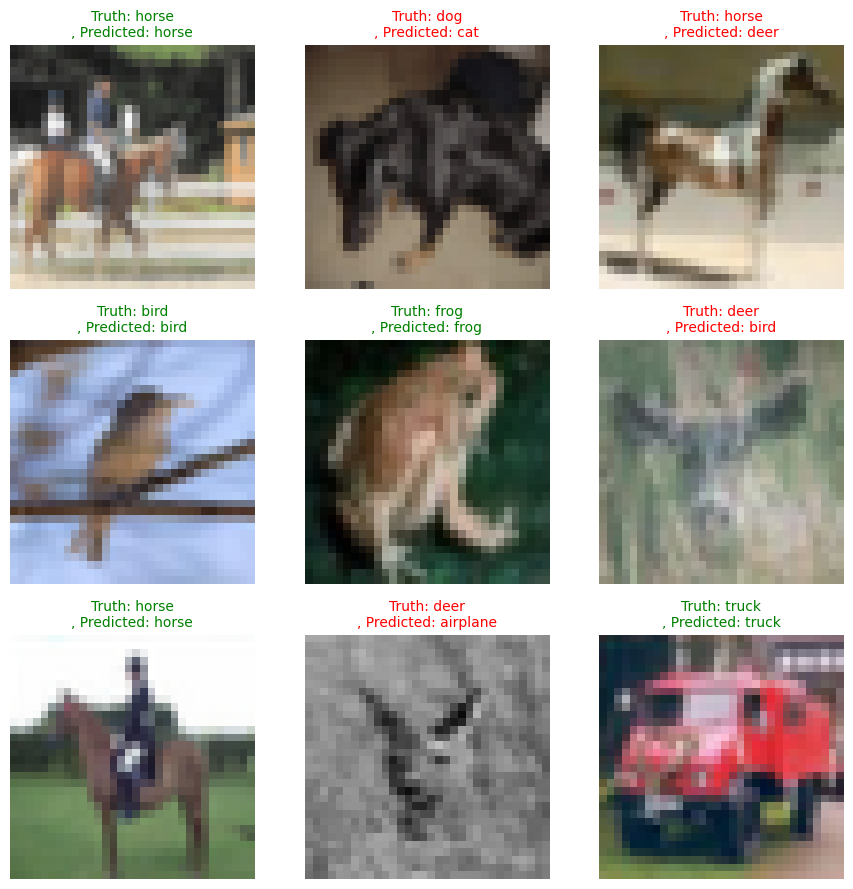

In [32]:
predict_and_plot_grid(model=model,
                      dataset=test_dataset,
                      classes=test_dataset.classes,
                      grid_size=3)

### 2. Loading model weights only

In [33]:
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS,
    MLP_DIM, DROP_RATE).to(device)

In [37]:
model.load_state_dict(torch.load("vit_weights.pth", map_location=device))
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-

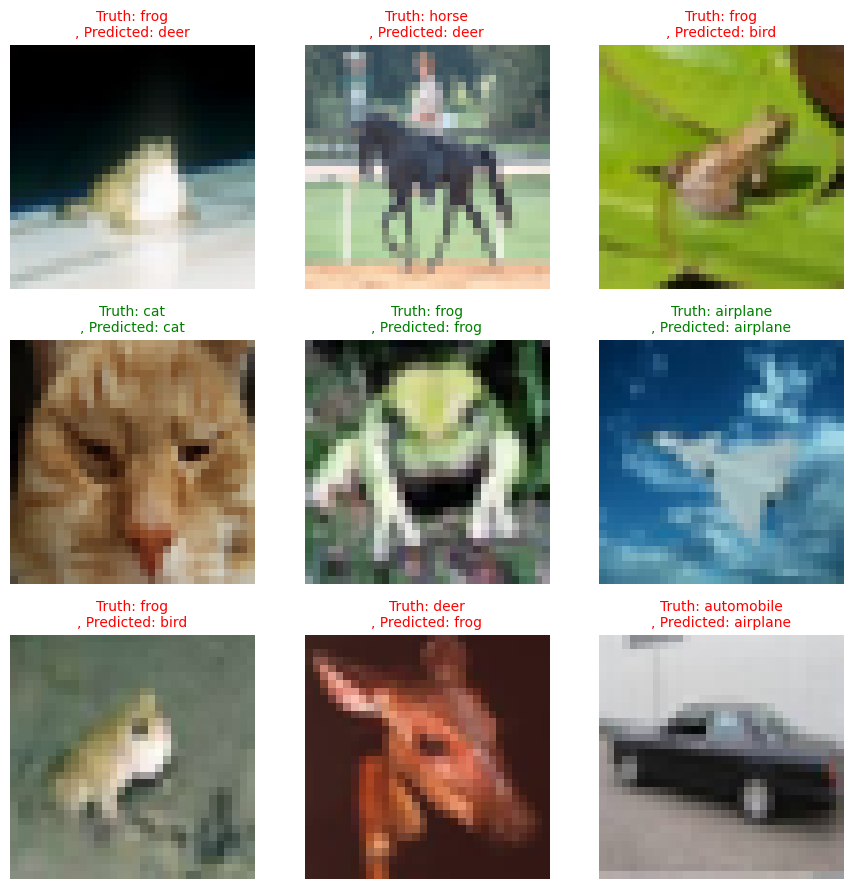

In [38]:
predict_and_plot_grid(model=model,
                      dataset=test_dataset,
                      classes=test_dataset.classes,
                      grid_size=3)

### 3. Fine Tuning head

In [39]:
pytorch_model= model

In [41]:
pytorch_model.head = nn.Sequential(
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 10)
)

In [43]:
# freezing everything else except head
for param in pytorch_model.parameters():
    param.requires_grad = False

for param in pytorch_model.head.parameters():
    param.requires_grad = True